# Requirements

In [ ]:
%pip install torch torchvision  # for gpu
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu  # for cpu
%pip install opencv-python
%pip install timm
%pip install shapely

!git clone https://github.com/facebookresearch/detectron2.git
%pip install --no-build-isolation -e detectron2
# reload window or restart kernel

# Model Fine-tuning

In [1]:
opts = [
    "train.seed=42",
    "train.device=cuda",  # for gpu
    "train.amp.enabled=true",  # for gpu
    # "train.device=cpu",  # for cpu
    # "train.amp.enabled=false",  # for cpu
    # pretrained models: https://github.com/facebookresearch/detectron2/tree/main/projects/ViTDet#pretrained-models
    "train.init_checkpoint=detectron2://ViTDet/COCO/cascade_mask_rcnn_vitdet_b/f325358525/model_final_435fa9.pkl",
    "dataloader.train.dataset.names=train_dataset",
    "dataloader.train.total_batch_size=1",
    "dataloader.train.num_workers=2",
    "dataloader.test.dataset.names=test_dataset",
    "dataloader.test.num_workers=2",
    "train.max_iter=500",
    "train.eval_period=100",
    "train.log_period=10",
    "model.roi_heads.num_classes=1",
    "model.proposal_generator.batch_size_per_image=256",  # default: 256
    "model.roi_heads.batch_size_per_image=128",  # default: 512
]

In [ ]:
from omegaconf import OmegaConf
from detectron2.config import LazyConfig

# pretrained models: https://github.com/facebookresearch/detectron2/tree/main/projects/ViTDet#pretrained-models
cfg = LazyConfig.load("./detectron2/projects/ViTDet/configs/COCO/cascade_mask_rcnn_vitdet_b_100ep.py")
cfg = LazyConfig.apply_overrides(cfg, opts)
print(OmegaConf.to_yaml(cfg))

In [ ]:
import logging
from detectron2.config import instantiate
from detectron2.utils.env import seed_all_rng
from detectron2.utils.logger import setup_logger
from detectron2.engine import SimpleTrainer, AMPTrainer, hooks, default_writers
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import inference_on_dataset, print_csv_format

# reference: https://github.com/facebookresearch/detectron2/blob/main/tools/lazyconfig_train_net.py

def custom_train(cfg):  # no multi-process or distributed training
    seed_all_rng(cfg.train.seed)
    setup_logger(cfg.train.output_dir, name="detectron2")

    model = instantiate(cfg.model)
    logger = logging.getLogger("detectron2")
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)

    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)

    train_loader = instantiate(cfg.dataloader.train)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)
    checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        trainer=trainer,
    )

    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer),
            hooks.EvalHook(cfg.train.eval_period, lambda: custom_eval(cfg, model)),
            hooks.PeriodicWriter(
                    default_writers(cfg.train.output_dir, cfg.train.max_iter),
                    period=cfg.train.log_period,
            ),
        ]
    )

    checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=False)
    trainer.train(0, cfg.train.max_iter)

def custom_eval(cfg, model):
    out = inference_on_dataset(
        model,
        instantiate(cfg.dataloader.test),
        instantiate(cfg.dataloader.evaluator),
    )
    print_csv_format(out)
    return out

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("train_dataset", {}, "data/train/annotations.json", "data/train/images")
register_coco_instances("test_dataset", {}, "data/test/annotations.json", "data/test/images")

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

custom_train(cfg)

# Model Inference

In [ ]:
test_score_thresh = 0.7
cfg.model.roi_heads.box_predictors[0].test_score_thresh = test_score_thresh
cfg.model.roi_heads.box_predictors[1].test_score_thresh = test_score_thresh
cfg.model.roi_heads.box_predictors[2].test_score_thresh = test_score_thresh

model = instantiate(cfg.model)
model.to(cfg.train.device)

"""
IMPORTANT:

In PyTorch 2.6, the default value of the `weights_only` argument in `torch.load` was changed
from `False` to `True`. This has not been factored into the fvcore library used by Detectron2.
More specifically, the `_load_file` function in `fvcore/common/checkpoint.py` now has a missing
`weights_only=False` argument. To circumvent this issue, set the PyTorch environment variable
`TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD` to `1`.
"""

import os
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"] = "1"

# DetectionCheckpointer(model).load(cfg.train.init_checkpoint)
DetectionCheckpointer(model).load(cfg.train.output_dir + "/model_final.pth")
print(type(model))

In [ ]:
import cv2
import torch

# image = cv2.imread("demo.jpg")
image = cv2.imread("input.png")
image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()
image_tensor = image_tensor.to("cpu")

model.eval()
with torch.no_grad():
    outputs = model.inference([{"image": image_tensor}])[0]
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

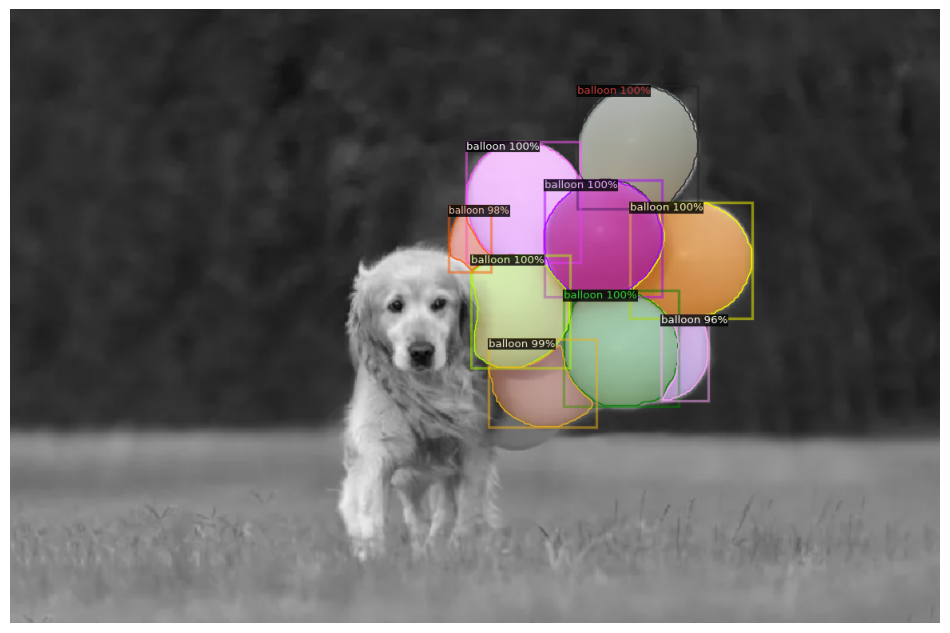

In [ ]:
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt

# metadata = MetadataCatalog.get("coco_2017_train")
metadata = MetadataCatalog.get("train_dataset")
v = Visualizer(image[:, :, ::-1], metadata, scale=1.2, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
plt.figure(figsize=(12, 12))
plt.imshow(out)
plt.axis("off")
plt.show()